# 階層的クラスタリング

この演習では下記のデータを用いて，階層的クラスタリングを体験します．
* とある購買データ
* 2018年度プロ野球打者成績データ

演習に必要な以下のライブラリを読み込んでおきます．

In [1]:
# 表形式のデータを操作するためのライブラリ
import pandas as pd

# 行列計算をおこなうためのライブラリ
import numpy as np

# 距離行列の計算のためのライブラリ
import scipy.spatial.distance as distance

# 階層的クラスタリング用のライブラリ
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

# グラフ描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set(style='ticks')
%matplotlib inline

また，この演習では日本語を含むグラフを生成するため，問題が生じないよう以下のおまじないコードを実行しておいてください．

In [2]:
!pip install japanize-matplotlib
import japanize_matplotlib 

---
## 例題1: とある購買データ

あるeコマースサイトにおける購買データを用いて階層的クラスタリングを実行してみましょう．
``data``フォルダにある``e-commerce.txt``ファイルは，
* 書籍
* 衣服
* 化粧品
* 食料品
* 飲料

を1年間で何回購入したかについて，100名の顧客のデータが記録されています（このデータは[書籍「手を動かしながら学ぶビジネスに活かすデータマイニング」のサポートページにて公開されているデータです](https://gihyo.jp/book/2014/978-4-7741-6674-2/support)）．
以下のコードを実行して，データを読み込みましょう．

In [3]:
url = "http://drive.hontolab.org/ymc-lecture2020/data/e_commerce.txt"
e_commerce_df = pd.read_table(url, header=0, sep=" ")

### ベクトルデータ間の距離の計算

Pythonで階層的クラスタリングを実行するには`scipy`ライブラリの``linkage``関数を用いますが，``linkage``関数は入力（第1引数）として **ベクトル間の距離情報（を格納した行列データ）** を求めます．
ここでベクトルとは，n個の特徴量からなるデータを意味します．今回の``e_commerce.txt``ファイルでは，1行1行が1名の顧客情報を表すベクトルデータとなります．

正攻法でやるならば，100行ある``e_commerce_df``の顧客データのすべての組み合わせを比較して，各顧客ベクトルの距離を計算する必要があります．
しかし，`scipy`ライブラリはそれを簡単に実行してくれる便利な関数``distance.pdist``を提供しています．

以下のコードを実行してベクトル間の距離を計算してみましょう．

In [4]:
dist_matrix = distance.pdist(e_commerce_df, metric='euclidean')

# 表示したい場合は以下のコードを#記号を削除して実行
#pd.DataFrame(distance.squareform(dist_matrix))

100行あるベクトルデータのすべての組み合わせについて距離を計算した結果（距離行列）が``dist_matrix``として得られました．
この距離行列を使って階層的クラスタリングを実行してみましょう．

### 階層的クラスタリングの実行

講義でも述べたように，階層的クラスタリングではクラスタの作り方の基準として
* 最長距離法（complete linkage method）
* 最短距離法（single linkage method）
* セントロイド法（centroid method）
* ウォード法（Ward's method）

などがあります．今回はウォード法を使ってみましょう．以下のコードを実行してみてください．

In [5]:
e_commerce_result = linkage(dist_matrix, method="ward")

階層的クラスタリングの結果が変数``e_commerce_result``に格納されました．

階層的クラスタリングにおいて，各要素（ベクトル）が徐々に併合されていく結果を示したものを**デンドログラム**と呼びます．デンドログラムを表示させてみましょう．以下のコードを実行してみてください．


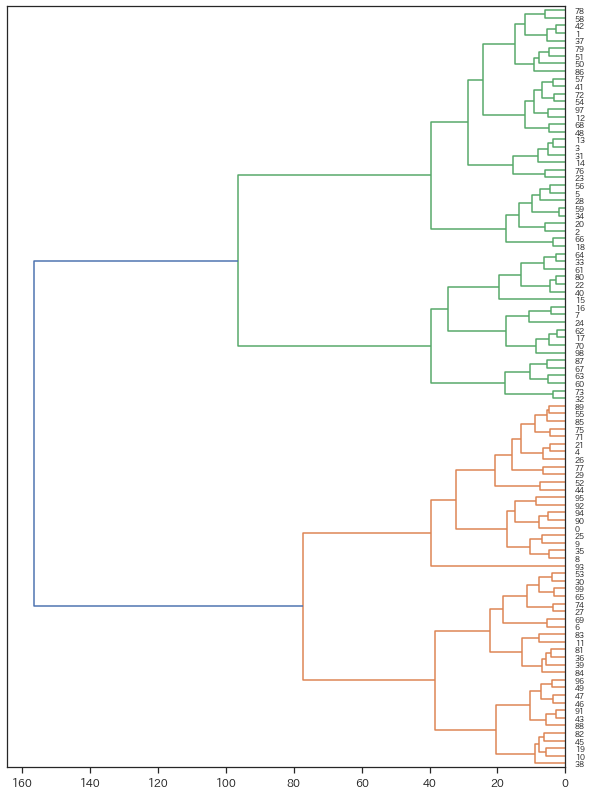

In [6]:
# 図の大きさの設定
plt.figure(figsize=(10, 14))

# 図の表示
fig = dendrogram(e_commerce_result,
                 leaf_font_size=8, orientation='left')
plt.show()

デンドログラムが表示されると，階層的クラスタリングを実行したという気分になりますね！

今回は顧客の一人一人について私たちは特に知識がないため，この図を眺めてもよく分かりません．そこで，適当な深さでデンドログラムの枝を切って，各要素をクラスタに分けてみましょう．つまりK-meansクラスタリングと同じようなことをします．その上で，
各クラスタに入っている要素がどのような性質を持っているかを分析していましょう．

デンドログラムの枝を切り，指定したクラスタ数に分割するには``cutree``関数を用います．``k``に数値を指定すると，デンドログラムをその数のクラスタに分割することができます．


In [7]:
# 4つのクラスタに分割
e_commerce_cluster = cut_tree(e_commerce_result, n_clusters=4)

# 最初の10件のみ表示
e_commerce_cluster[:10, 0]

array([0, 1, 1, 1, 0, 1, 2, 3, 0, 0])

変数``e_commerce_cluster``に100名の顧客のクラスタ割り当て番号が格納されました．

### クラスタの分析

さて，クラスタリングの結果は変数``e_commerce_cluster``に得られましたが，各クラスタがどのような購買傾向を持っているかを分析するには，``e_commerce_df``データと照らし合わせる必要があります．
そこで，以下のコードを実行して，``e_commerce_cluster``と``e_commerce_df``を結合してみましょう．

In [8]:
# 結合
new_e_commerce_df = e_commerce_df.assign(
    cluster_id = e_commerce_cluster[:, 0]
)

# 先頭の数件のみ表示
new_e_commerce_df.head()

,books,cloths,cosmetics,foods,liquors,cluster_id
0,43,0,3,4,10,0
1,25,5,5,3,11,1
2,19,0,2,3,8,1
3,31,3,3,4,5,1
4,46,9,2,5,7,0


各顧客データがどのクラスタに分類するかのデータが得られました．このデータを用いて，クラスタ毎に書籍の平均購買数，衣類の平均購買数などを調べてみましょう．

今回の分析のように，クラスタ毎に何らかの情報をまとめて計算することを**集約演算**と呼びます．
やや複雑に見えますが，以下のコードを実行してみてください．

In [9]:
new_e_commerce_df.groupby(
    'cluster_id' # cluster_idでデータをまとめる
).agg(
    'mean' # まとまり毎に平均値を算出
)

,books,cloths,cosmetics,foods,liquors
cluster_id,,,,,
0,48.363636,8.454545,4.636364,5.636364,3.863636
1,26.562500,6.187500,4.500000,4.750000,5.531250
2,35.923077,17.730769,4.423077,5.000000,6.923077
3,9.200000,14.400000,5.350000,4.250000,8.400000


クラスタ毎に書籍，衣類，化粧品，食料品，飲料の平均購買数が求まりました．クラスタ毎に少しずつ特徴が異なることが確認できます．

---
## 例題2: 2018年度プロ野球打者成績データ

例題1のデータは見ず知らずの顧客のデータであったため，クラスタリングをしても予想される結果がイメージしにくかったと思います．そこで次は実データを分析してみましょう．

下記コマンドを実行して，``baseball_stats_2018.tsv``ファイルを読み込みます．
このデータは2018年度のプロ野球において，規定打席に達した打者の成績（例：「打率」「出塁率」「長打率」）を記録したものです．

In [10]:
# データの読み込み
url = "http://drive.hontolab.org/ymc-lecture2020/data/baseball_stats_2018.tsv"
stats_df = pd.read_table(url, header=0, sep="\t", index_col='選手名')

# 最初の数件を表示
stats_df.head()

,チーム,打率,打席数,打数,安打数,ホームラン数,打点,盗塁,盗塁刺,盗塁成功率,犠打,犠飛,四球,三振,併殺打,出塁率,長打率
選手名,,,,,,,,,,,,,,,,,
山田 哲人,ヤクルト,0.329,646,557,183,38,100,34,4,0.895,0,3,81,111,11,0.416,0.610
中村 剛也,西武,0.278,599,521,145,37,124,1,0,1.000,0,3,68,172,12,0.367,0.559
松田 宣浩,ソフトバンク,0.287,603,533,153,35,94,8,10,0.444,0,8,60,135,17,0.357,0.533
柳田 悠岐,ソフトバンク,0.363,605,502,182,34,99,32,8,0.800,0,1,88,101,9,0.469,0.631
レアード,日本ハム,0.231,554,498,115,34,97,1,0,1.000,0,4,43,129,18,0.301,0.488


このデータに対して，階層的クラスタリングを実行して傾向が似通った選手をグルーピングしてみましょう．

データをご覧になると分かるように，``stats_df``には「打率」「安打数」「ホームラン数」といった成績情報以外に「チーム名」（とデータのラベルとして「選手名」）が含まれています．
今回の分析では野手成績に関係する「打率」〜「長打率」だけに焦点をしぼって分析をします．

``stats_df``では「打率」〜「長打率」は1〜17列目（0列スタート）に格納されています．
``stats_df``から1〜17列目だけを抜き出すには，下記のようなコードを書きます．

In [11]:
stats_df.iloc[:, 1:17]

,打率,打席数,打数,安打数,ホームラン数,打点,盗塁,盗塁刺,盗塁成功率,犠打,犠飛,四球,三振,併殺打,出塁率,長打率
選手名,,,,,,,,,,,,,,,,
山田 哲人,0.329,646,557,183,38,100,34,4,0.895,0,3,81,111,11,0.416,0.610
中村 剛也,0.278,599,521,145,37,124,1,0,1.000,0,3,68,172,12,0.367,0.559
松田 宣浩,0.287,603,533,153,35,94,8,10,0.444,0,8,60,135,17,0.357,0.533
柳田 悠岐,0.363,605,502,182,34,99,32,8,0.800,0,1,88,101,9,0.469,0.631
レアード,0.231,554,498,115,34,97,1,0,1.000,0,4,43,129,18,0.301,0.488
李 大浩,0.282,584,510,144,31,98,0,1,0.000,0,3,62,109,17,0.368,0.524
中田 翔,0.263,611,539,142,30,102,1,0,1.000,0,7,64,120,11,0.339,0.479
メヒア,0.235,525,473,111,27,89,0,0,0.000,0,2,45,153,14,0.307,0.471
畠山 和洋,0.268,584,512,137,26,105,0,0,0.000,0,8,62,92,10,0.344,0.471


この方法を使って，選手データをクラスタリングしてみましょう．

例題1と同様，今回の分析では階層的クラスタリングのタイプとして**ウォード法**を用いることにします．
下記のコードを実行すると，階層的クラスタリングを行い，その結果をデンドログラムとして表示します．

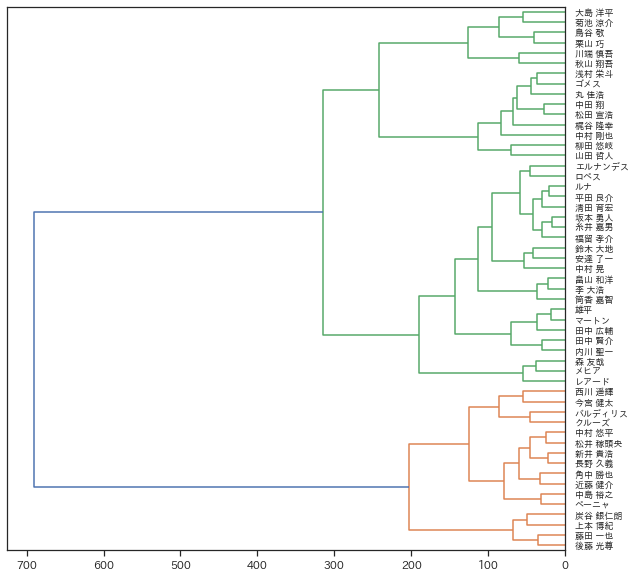

In [12]:
# 距離行列の計算
stats_dist_matrix = distance.pdist(stats_df.iloc[:, 1:17], metric='euclidean')

# 階層的クラスタリングの実行
stats_result = linkage(stats_dist_matrix, method="ward")

# デンドログラムの表示
plt.figure(figsize=(10, 10))
fig = dendrogram(stats_result, labels=stats_df.index, 
                leaf_font_size=9, orientation='left')
plt.show()

デンドログラムが表示されました．プロ野球に関心のある方からご覧になって，このクラスタリング結果は妥当なものでしょうか？

例題1と同様に，各クラスタの平均的なスコアを計算してみましょう．
図を見ると，今回の結果から，データはざっくり見ると6クラスタに分かれそうです．
とりあえず6クラスタに分けたときに，各クラスタの平均スコアがどうなっているかを分析してみましょう．

In [13]:
# 6つのクラスタに分割
stats_cluster = cut_tree(stats_result, n_clusters=6)

# クラスタ情報と選手データを結合
new_stats_df = stats_df.assign(
    cluster_id = stats_cluster[:, 0]
)

# 各クラスタの平均スコアを計算
new_stats_df.groupby(
    'cluster_id' # cluster_idでデータをまとめる
).agg(
    'mean' # まとまり毎に平均値を算出
)

,打率,打席数,打数,安打数,ホームラン数,打点,盗塁,盗塁刺,盗塁成功率,犠打,犠飛,四球,三振,併殺打,出塁率,長打率
cluster_id,,,,,,,,,,,,,,,,
0,0.287222,611.444444,528.777778,151.777778,26.222222,89.000000,14.555556,5.777778,0.675000,0.888889,4.222222,72.222222,131.555556,10.666667,0.375222,0.495333
1,0.251000,536.666667,481.666667,120.666667,26.000000,84.666667,0.333333,1.333333,0.333333,0.000000,3.000000,44.000000,141.666667,12.333333,0.321667,0.475667
2,0.280158,573.578947,508.631579,142.473684,13.684211,67.105263,5.631579,3.421053,0.494579,4.947368,3.578947,52.789474,80.263158,11.315789,0.349842,0.421421
3,0.263083,502.750000,441.416667,116.000000,9.666667,49.750000,6.000000,2.250000,0.532167,7.166667,2.750000,46.250000,78.333333,9.333333,0.338000,0.385667
4,0.293000,639.833333,565.666667,166.500000,8.666667,42.500000,12.333333,7.333333,0.638833,13.000000,2.333333,55.333333,78.666667,9.333333,0.357500,0.397333
5,0.242750,447.500000,394.750000,95.750000,5.500000,37.750000,10.000000,5.500000,0.494750,19.250000,3.250000,25.000000,58.500000,4.750000,0.294000,0.328750


各クラスタの特徴は以下のような感じでしょうか：
* 第1クラスタ: 打率も高く，ホームランも盗塁もできるユーティリティプレーヤー
* 第2クラスタ: ホームランヒッター
* 第3クラスタ: 打率もホームランもそこそこ高い6番バッタータイプ
* 第4クラスタ: これといって特徴はない
* 第5クラスタ: 出塁率が高く盗塁も多く足が速い，リードオフ・マンタイプ
* 第6クラスタ: 打率は高くないが，堅実に犠打でランナーを進める，2番バッタータイプ